In [1]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage
import cv2
%matplotlib inline

In [3]:
training_file = "data/train.pickle"
validation_file= "data/valid.pickle"
testing_file = "data/test.pickle"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

print("X_train shape:", X_train[0].shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid[0].shape)
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test[0].shape)
print("y_test shape:", y_test.shape)

X_train shape: (32, 32, 3)
y_train shape: (34799,)
X_valid shape: (32, 32, 3)
y_valid shape: (4410,)
X_test shape: (32, 32, 3)
y_test shape: (12630,)


In [6]:
n_train = len(X_train)
n_valid = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

In [7]:
print("Number of training examples = ", n_train)
print("Number of validation example = ", n_valid)
print("Number of testing samples = ", n_test)
print("Shape of first training image = ", image_shape[0], "w x", image_shape[1], "h x", image_shape[2], "d")
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation example =  4410
Number of testing samples =  12630
Shape of first training image =  32 w x 32 h x 3 d
Number of classes =  43


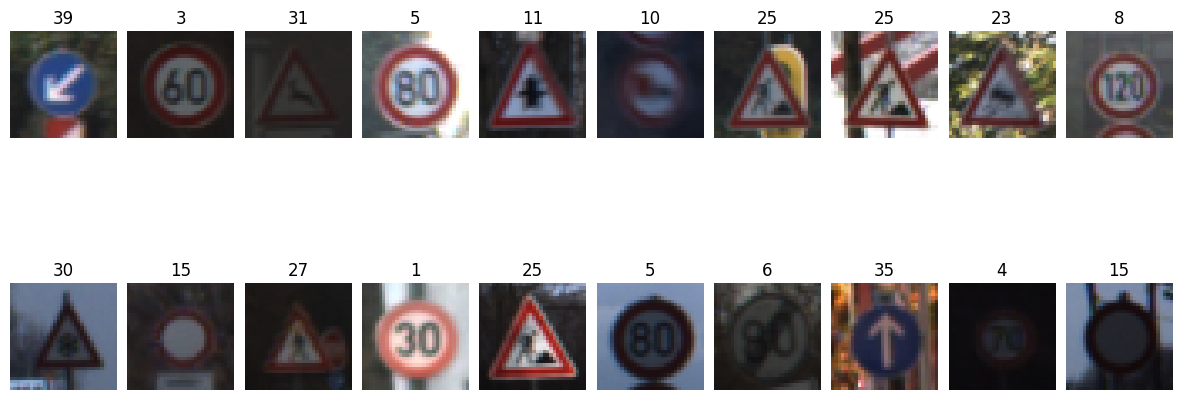

In [10]:
fig, axs = plt.subplots(2,10, figsize=(15,6))
fig.subplots_adjust(hspace=.2, wspace=.1)
axs = axs.ravel()

for i in range(20):
    index = random.randint(0,len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

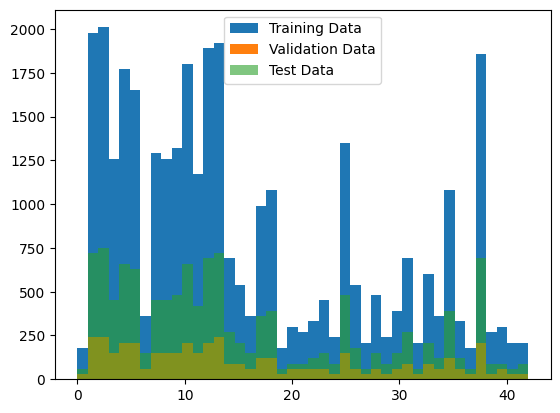

In [12]:
a = y_train
b = y_valid
c = y_test
bins = n_classes

plt.hist(a, bins, alpha=1, label='Training Data')
plt.hist(b, bins, alpha=1, label='Validation Data')
plt.hist(c, bins, alpha=0.6, label='Test Data')
plt.legend(loc='upper center')

plt.show()